In [30]:
from pandas import MultiIndex, Int16Dtype
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set_style('darkgrid')

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge,LinearRegression, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [32]:
%run "../7. Prediccion/Funciones_Prepara_Prediccion.ipynb"

### Preparación datos

In [33]:

bicimad_def = _dataBaseOriginal("../../Data/DataFrame_Final_Cierre_Cluster.csv")


In [34]:
bicimad_def

,ESTACION,ANIO,MES,DIA,TEMPORADA,DIA_SEMANA,Es_Festivo,Es_FinSemana,DEMANDA,TEMP_MAX,TEMP_MIN,HUMEDAD,VIENTO,PRESION,PRECIPITACION_1h,PRECIPITACION_3h,DESC_TIEMPO
0,1,2018,1,1,INVIERNO,2,1,0,39,10.98,2.67,69.818182,7.080909,1030.727273,0.00,0.00,Clouds
1,1,2018,1,2,INVIERNO,3,0,0,75,12.69,7.24,73.210526,5.420000,1031.842105,0.00,0.00,Clouds
2,1,2018,1,3,INVIERNO,4,0,0,68,13.58,8.13,90.176471,4.794118,1031.588235,0.00,0.00,Clouds
3,1,2018,1,4,INVIERNO,5,0,0,77,13.99,8.28,84.105263,5.334211,1025.789474,0.00,0.00,Clouds
4,1,2018,1,5,INVIERNO,6,0,0,55,10.88,8.46,84.363636,5.445000,1012.045455,4.37,1.65,Clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129326,175,2020,2,25,INVIERNO,3,0,0,87,17.48,5.91,54.769231,6.007692,1018.307692,0.00,0.00,Clouds
129327,175,2020,2,26,INVIERNO,4,0,0,158,15.18,6.22,48.600000,5.321000,1020.500000,0.00,0.00,Clear
129328,175,2020,2,27,INVIERNO,5,0,0,173,18.41,6.35,49.095238,6.207143,1020.619048,0.00,0.00,Clear
129329,175,2020,2,28,INVIERNO,6,0,0,166,18.38,5.74,49.428571,2.174762,1019.571429,0.00,0.00,Clear


In [35]:
#cat_cols= ['ANIO', 'MES', 'DIA_SEMANA', 'TEMPORADA','DESC_TIEMPO','AM_PM', 'Es_Festivo', 'Es_FinSemana']
cat_cols= ['MES', 'DIA_SEMANA', 'TEMPORADA', 'Es_Festivo', 'Es_FinSemana','DESC_TIEMPO']
#cat_cols= ['MES', 'DIA_SEMANA','Es_Festivo', 'Es_FinSemana']

num_cols= ['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION']

In [36]:
bicimad = bicimad_def

#bicimad = datos.drop(['CLUSTER_FullCols','TEMPORADA_NUM','CLUSTER_soloDemanda','CLUSTER_soloGeo','DIA','ANIO','DESC_TIEMPO_detalle'], axis=1)


bicimad['FECHA'] =pd.to_datetime({'year': bicimad['ANIO'],
                                          'month': bicimad["MES"]
                                          ,'day':  bicimad['DIA']
                                          },
                                          format='%d-%m-%Y', errors='coerce')

bicimad['MES']   = bicimad['MES'].astype('category')
bicimad['DIA_SEMANA'] = bicimad['DIA_SEMANA'].astype('category')
bicimad['Es_Festivo'] = bicimad['Es_Festivo'].astype('category')
bicimad['Es_FinSemana'] = bicimad['Es_FinSemana'].astype('category')
bicimad['DESC_TIEMPO'] = bicimad['DESC_TIEMPO'].astype('category')

bicimad = pd.get_dummies(bicimad, columns=cat_cols, drop_first=True)

X = bicimad[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION','PRECIPITACION_1h','PRECIPITACION_3h']]

scaler = StandardScaler()
bicimad[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION','PRECIPITACION_1h','PRECIPITACION_3h']] = scaler.fit_transform(X)

bicimad = bicimad.drop(['ANIO','DIA'], axis=1)

bicimad

,ESTACION,DEMANDA,TEMP_MAX,TEMP_MIN,HUMEDAD,VIENTO,PRESION,PRECIPITACION_1h,PRECIPITACION_3h,FECHA,...,TEMPORADA_VERANO,Es_Festivo_1,Es_FinSemana_1,DESC_TIEMPO_Clouds,DESC_TIEMPO_Drizzle,DESC_TIEMPO_Fog,DESC_TIEMPO_Mist,DESC_TIEMPO_Rain,DESC_TIEMPO_Snow,DESC_TIEMPO_Thunderstorm
0,1,39,-1.026930,-1.067735,0.725362,1.669834,1.987357,-0.269958,-0.233356,2018-01-01,...,0,1,0,1,0,0,0,0,0,0
1,1,75,-0.832167,-0.403777,0.907454,0.805625,2.143212,-0.269958,-0.233356,2018-01-02,...,0,0,0,1,0,0,0,0,0,0
2,1,68,-0.730798,-0.274473,1.818144,0.479964,2.107721,-0.269958,-0.233356,2018-01-03,...,0,0,0,1,0,0,0,0,0,0
3,1,77,-0.684101,-0.252680,1.492257,0.760986,1.297043,-0.269958,-0.233356,2018-01-04,...,0,0,0,1,0,0,0,0,0,0
4,1,55,-1.038320,-0.226529,1.506126,0.818633,-0.624397,2.112318,1.256768,2018-01-05,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129326,175,87,-0.286600,-0.597008,-0.082428,1.111414,0.251076,-0.269958,-0.233356,2020-02-25,...,0,0,0,1,0,0,0,0,0,0
129327,175,158,-0.548563,-0.551969,-0.413577,0.754113,0.557564,-0.269958,-0.233356,2020-02-26,...,0,0,0,0,0,0,0,0,0,0
129328,175,173,-0.180676,-0.533082,-0.386994,1.215193,0.574207,-0.269958,-0.233356,2020-02-27,...,0,0,0,0,0,0,0,0,0,0
129329,175,166,-0.184093,-0.621707,-0.369102,-0.882947,0.427748,-0.269958,-0.233356,2020-02-28,...,0,0,0,0,0,0,0,0,0,0


In [37]:
bicimad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129331 entries, 0 to 129330
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ESTACION                  129331 non-null  int64         
 1   DEMANDA                   129331 non-null  int64         
 2   TEMP_MAX                  129331 non-null  float64       
 3   TEMP_MIN                  129331 non-null  float64       
 4   HUMEDAD                   129331 non-null  float64       
 5   VIENTO                    129331 non-null  float64       
 6   PRESION                   129331 non-null  float64       
 7   PRECIPITACION_1h          129331 non-null  float64       
 8   PRECIPITACION_3h          129331 non-null  float64       
 9   FECHA                     129331 non-null  datetime64[ns]
 10  MES_2                     129331 non-null  uint8         
 11  MES_3                     129331 non-null  uint8         
 12  ME

In [38]:
seed = 99

models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed)))
models.append(('GBR', GradientBoostingRegressor(random_state=seed)))
models.append(('LGBMR', LGBMRegressor(random_state=seed)))
models.append(('XGBR', XGBRegressor(random_state=seed)))

In [39]:
Estaciones = [1]

# Cluster 0 -> 145
# Cluster 1 -> 58
# Cluster 2 -> 148
# Cluster 3 -> 157
# Cluster 4 -> 163

In [40]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid_RF = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3,5,7],
    'min_samples_leaf': [1,2,3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,500,1000]
}

param_grid_GB = {'learning_rate': [0.01,0.02,0.04, 0.1],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
               'max_depth'    : [80, 90, 100,110]
                 }

param_grid_LGBM = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt', 'dart'],
    'objective' : ['binary'],
    'max_bin':[255, 510],
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

param_grid_XGB = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [80, 90, 100,110]
        }

## Tuneado modelo Random Forest

In [41]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print('Columnas: '+str(len(bicimad_est.columns)))
    
    # Create a based model
    rf = RandomForestRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid_RF, cv = 2, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Estacion: 1

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1000}


## Tuneado modelo Gradient Boosting

In [42]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print('Columnas: '+str(len(bicimad_est.columns)))
    
    # Create a based model
    GB = GradientBoostingRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = GB, param_grid = param_grid_GB, cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Estacion: 1

Fitting 3 folds for each of 256 candidates, totalling 768 fits
{'learning_rate': 0.02, 'max_depth': 80, 'n_estimators': 100, 'subsample': 0.2}


## Tuneado modelo LBGM

In [43]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print('Columnas: '+str(len(bicimad_est.columns)))
    
    # Create a based model
    LGBM = LGBMRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = LGBM, param_grid = param_grid_LGBM, cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Estacion: 1

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.005, 'max_bin': 255, 'n_estimators': 8, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}


## Tuneado XGBoost

In [44]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print('Columnas: '+str(len(bicimad_est.columns)))
    
    # Create a based model
    XGB = XGBRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = XGB, param_grid = param_grid_XGB, cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Estacion: 1

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
{'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 80, 'min_child_weight': 5, 'subsample': 1.0}


# Comparación de Modelos

In [20]:
estacionCompara = 1

In [45]:
bicimad_est = bicimad[bicimad['ESTACION'] == estacionCompara]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']


models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed,
                                           bootstrap= True, 
                                           max_depth= 80, 
                                           max_features= 7, 
                                           min_samples_leaf= 1, 
                                           min_samples_split= 8, 
                                           n_estimators= 1000)))

models.append(('GBR', GradientBoostingRegressor(random_state=seed,
                                               learning_rate= 0.02, 
                                                max_depth= 80, 
                                                n_estimators= 100, 
                                                subsample= 0.2)))

models.append(('LGBMR', LGBMRegressor(random_state=seed,
                                      boosting_type= 'gbdt', 
                                      colsample_bytree= 0.64, 
                                      learning_rate= 0.005, 
                                      max_bin= 255, 
                                      n_estimators= 8, 
                                      num_leaves= 6, 
                                      objective= 'binary', 
                                      reg_alpha= 1, 
                                      reg_lambda= 1, 
                                      subsample= 0.7)))

models.append(('XGBR', XGBRegressor(random_state=seed,
                                    colsample_bytree= 0.8, 
                                    gamma= 1, 
                                    max_depth= 80, 
                                    min_child_weight= 5, 
                                    subsample= 1.0)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print()

Model: RFR 
R^2: 0.84.
MSE: 1724.41
RMSE: 41.53

Model: GBR 
R^2: 0.79.
MSE: 1903.45
RMSE: 43.63

Model: LGBMR 
R^2: -5.45.
MSE: 2222.14
RMSE: 47.14

Model: XGBR 
R^2: 1.00.
MSE: 2147.80
RMSE: 46.34



-5.659629071639552


,Importance
TEMP_MAX,0.241216
TEMP_MIN,0.158051
HUMEDAD,0.104507
VIENTO,0.082032
PRESION,0.076618
MES_12,0.067388
Es_FinSemana_1,0.035737
PRECIPITACION_1h,0.027493
MES_9,0.024181
PRECIPITACION_3h,0.017115


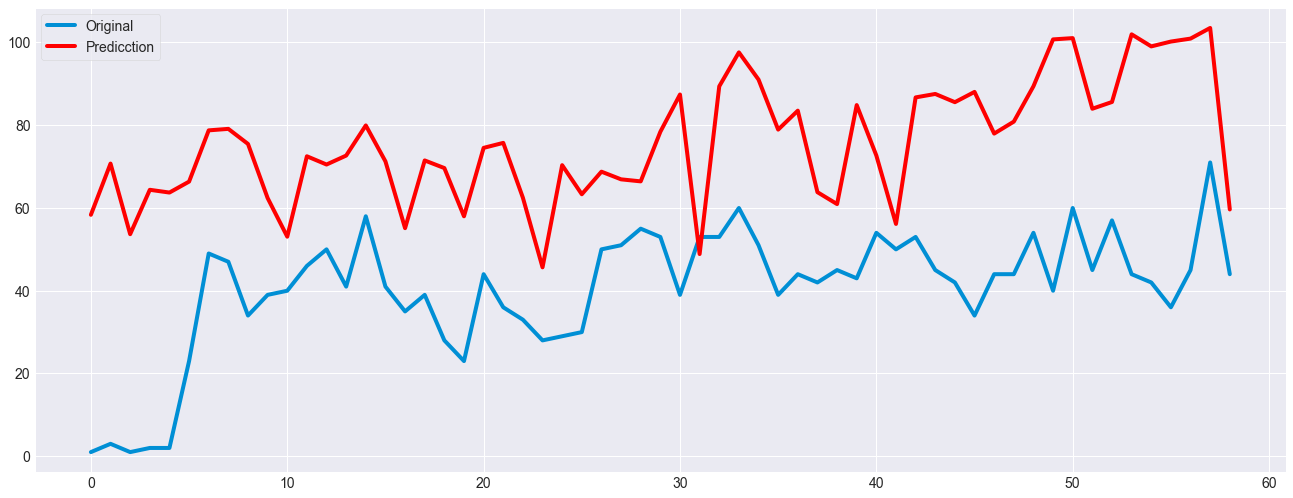

In [46]:
bicimad_est = bicimad[bicimad['ESTACION'] == estacionCompara]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']


model = RandomForestRegressor(random_state=seed,
                                           bootstrap= True, 
                                           max_depth= 80, 
                                           max_features= 7, 
                                           min_samples_leaf= 1, 
                                           min_samples_split= 8, 
                                           n_estimators= 1000)

resultado = model.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model.score(X_test, y_test, sample_weight=None)


print(score)
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances[:30]


In [47]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True
            )

cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_score,train_score
0,0.632550,0.037712,0.536465,0.812184
1,0.638868,0.037985,0.556446,0.808880
2,0.636079,0.036264,0.435979,0.835780
3,0.645749,0.038005,0.570166,0.808015
4,0.630281,0.039001,0.430507,0.830142
5,0.627559,0.040097,0.545578,0.815847
6,0.649317,0.039062,0.553481,0.812754
7,0.647988,0.039281,0.500410,0.819505
8,0.670077,0.038002,0.463834,0.827563
9,0.655684,0.051065,0.477518,0.828672


In [48]:
joblib.dump(resultado, '../Modelos/Modelo_'+str(estacionCompara)+'.pkl', compress=9)

['../Modelos/Modelo_1.pkl']